In [87]:
import pandas as pd
import numpy as np
import os
import glob
path="processed_gdelt2/"

pd.set_option('display.max_columns', 150)

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ciso8601
from datetime import datetime
from dateutil import parser
import concurrent.futures
import time
import csv
import re


import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots

ply.init_notebook_mode(connected=True)


import colorlover as cl
from IPython.display import HTML

chosen_colors=cl.scales['7']['qual'][np.random.choice(list(cl.scales['7']['qual'].keys()))]

print('The color palette chosen for this notebook is:')
HTML(cl.to_html(chosen_colors))

The color palette chosen for this notebook is:


In [2]:
file_2021_10 = sorted(os.listdir('processed_gdelt2/'))[-10:]

In [3]:
files = glob.glob(os.path.join(path,"2020*.csv"))

In [4]:
headers = ['gkg_id', 'date', 'source', 'source_name', 'doc_id', 
        'themes', 'locations', 'persons', 'orgs', 
        'tone', 'pos', 'neg', 'polarity', 'ard', 'srd',
        'wc', 
        'lexicode_neg', 'lexicode_pos', # c3.*
        'MACROECONOMICS', 'ENERGY', 'FISHERIES', 
        'TRANSPORTATION', 'CRIME', 'SOCIAL_WELFARE',
        'HOUSING', 'FINANCE', 'DEFENCE', 'SSTC',
        'FOREIGN_TRADE', 'CIVIL_RIGHTS', 
        'INTL_AFFAIRS', 'GOVERNMENT_OPS',
        'LAND-WATER-MANAGEMENT', 'CULTURE',
        'PROV_LOCAL', 'INTERGOVERNMENTAL',
        'CONSTITUTIONAL_NATL_UNITY', 'ABORIGINAL',
        'RELIGION', 'HEALTHCARE', 'AGRICULTURE',
        'FORESTRY', 'LABOUR', 'IMMIGRATION',
        'EDUCATION', 'ENVIRONMENT',
        'finstab_pos', 'finstab_neg', 'finstab_neutral',
        'finsent_neg', 'finsent_pos', 'finsent_unc',
        'opin_neg', 'opin_pos',
        'sent_pos', 'sent_neg', 'sent_pol'
]

In [5]:
len(files)

32532

In [15]:
''' Tone--- (floating point number) This is the average “tone” of the document as a whole.
The score ranges from -100 (extremely negative) to +100 (extremely positive). Common
values range between -10 and +10, with 0 indicating neutral. '''

''' Positive Score--- (floating point number) This is the percentage of all words in the article
that were found to have a positive emotional connotation. Ranges from 0 to +100. '''

''' Negative Score--- (floating point number) This is the percentage of all words in the
article that were found to have a positive emotional connotation. Ranges from 0 to
+100. '''

''' Polarity--- (floating point number) This is the percentage of words that had matches in
the tonal dictionary as an indicator of how emotionally polarized or charged the text is.
If Polarity is high, but Tone is neutral, this suggests the text was highly emotionally
charged, but had roughly equivalent numbers of positively and negatively charged
emotional words. '''


''' c 3.4 --- negative positive ( positive word preceded by a negation (used to convey negative sentiment) and, 
    c 3.3 --- negative negative ( a negative word preceded by a negation, used to convey positive sentiment )'''

def merge_csv():
    start = time.time()
#     df_each = (pd.read_csv(f,names=headers,header=None) for f in files)
#     df_merge = pd.concat(df_each, ignore_index=True)
#     df = df_merge.copy()
#     end = time.time()
#     print(f"Processing the data took : {round(end-start,2)} seconds")
    
    header_written = False
    ''' Pandas method takes a longer timer for merge and hence have made it in pure python to boost up'''

#     with open('gdelt.csv', 'w', newline="") as fout:
#         wout = csv.writer(fout, delimiter=',')
#         files = [x for x in glob.glob("processed_gdelt2/2020*.csv") if x != 'gdelt.csv']
#         for file in files:
#             print("processing {}".format(file))
#             with open(file) as fin:
#                 cr = csv.reader(fin,delimiter=',')
#                 if not header_written:
#                     wout.writerow(headers)
#                     header_written = True
#                 wout.writerows(cr)    
    
    df = pd.read_csv("Gdelt_2020.csv")
    df_au = pd.read_csv("gdelt_2020_au.csv")




#     df['date'].dropna(inplace=True)
    
    df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d%H%M%S")
    df_au['date'] = pd.to_datetime(df_au['date'], format = "%Y%m%d%H%M%S")

    

    end = time.time()
    print(f"Processing the datetime took : {round(end-start,2)} seconds")

    
    return df, df_au



In [16]:
%%time

df1,df1_au = merge_csv()


Processing the datetime took : 59.5 seconds
CPU times: user 56.8 s, sys: 2.66 s, total: 59.5 s
Wall time: 59.5 s


In [17]:
print(df1['date'].min())
df1['date'].max()

2020-01-01 00:00:00


Timestamp('2020-12-31 23:45:00')

### Lockdown Feature inclusion


In [18]:
''' 2020/03/21 - Alert level 2
    2020/03/23  - Alert level 3
    2020/03/25  - Alert level 4
    2020/04/27 - 3
    2020/05/13 - 2
    2020/06/08 - 1
    2020/08/12 - A 3 & R 2
    2020/08/30 - 2
    2020/09/21 - A2 & R1
    2020/10/7  - 1
    2021/02/14 - A 3 R 2
    2021/02/17 - A 2 R 1 
    2021/02/28 - A 3 R 1
    2021/03/07 - A 2 R 1
    2021/03/12 - 1
    '''

unique_dates = pd.to_datetime(df1['date'].unique())
date_to_lockdown = {}
for date in unique_dates:

    date_str = date.strftime('%Y%m%d')
    if date < datetime(2020, 3, 23):
        date_to_lockdown[date_str] = 'AL 2'
    elif date < datetime(2020, 3, 25):
        date_to_lockdown[date_str] = 'AL 3'
    elif date < datetime(2020, 4, 27):
        date_to_lockdown[date_str] = 'AL 4'
    elif date < datetime(2020, 5, 13):
        date_to_lockdown[date_str] = 'AL 3'
    elif date < datetime(2020, 6, 8):
        date_to_lockdown[date_str] = 'AL 2'
    elif date < datetime(2020, 8, 12):
        date_to_lockdown[date_str] = 'AL 1'
    elif date < datetime(2020, 8, 30):
        date_to_lockdown[date_str] = 'AKL-3 Rest-2'
    elif date < datetime(2020, 9, 21):
        date_to_lockdown[date_str] = 'AL 2'
    elif date < datetime(2020, 10, 7):
        date_to_lockdown[date_str] = 'AKL-2 Rest-1'
    elif date < datetime(2021, 2, 14):
        date_to_lockdown[date_str] = 'AL 1'
    elif date < datetime(2021, 2, 17):
        date_to_lockdown[date_str] = 'AKL-3 Rest-2'
    elif date < datetime(2021, 2, 28):
        date_to_lockdown[date_str] = 'AKL-2 Rest-1'
    elif date < datetime(2021, 3, 7):
        date_to_lockdown[date_str] = 'AKL-3 Rest-1'
    elif date < datetime(2021, 3, 12):
        date_to_lockdown[date_str] = 'AKL-2 Rest-1'
    else:
        date_to_lockdown[date_str] ='AL 1'

df1['Lockdown'] = df1['date'].dt.strftime('%Y%m%d').map(date_to_lockdown)

In [19]:
# df1 = pd.read_feather('df1.ft')      # cleaned df

In [20]:
au_city = pd.read_csv("au.csv")
au_city = list(au_city['city'])

In [21]:
au_city = au_city[:15]

In [22]:
df1[df1['date'] == datetime(2020, 10, 22)].source_name.count()

0

### Region Wise Analysis

In [23]:
regions = [
    "Northland", "Auckland", "Waikato", "Bay of Plenty", "Gisborne", 
    "Hawke's Bay", "Taranaki", "Manawatu-Whanganui", "Wellington", "Tasman",
    "Nelson", "Marlborough", "West Coast", "Canterbury", "Otago", "Southland"
]

In [29]:
df1['Region'] = df1['locations'].str.findall(r"|".join(regions)).apply(", ".join)

In [30]:
df1_au['Region'] = df1_au['locations'].str.findall(r"|".join(au_city)).apply(", ".join)

In [31]:
def region(region):
    
    region = region.split(',')
    region = [region.replace(' ', '') for region in region]
#     region = list(filter(lambda x: x.strip(), region))
    region = list(set(region))
    region = ["New Zealand (General)" if region == '' else region for region in region]
    
    return region

def region_au(region):
    
    region = region.split(',')
    region = [region.replace(' ', '') for region in region]
#     region = list(filter(lambda x: x.strip(), region))
    region = list(set(region))
    region = ["Australia (General)" if region == '' else region for region in region]
    
    return region

df1['Region'] = df1['Region'].apply(lambda x: region(x))

df1_au['Region'] = df1_au['Region'].apply(lambda x: region_au(x))


# list to str

df1['Region'] = df1['Region'].agg(lambda x: ','.join(map(str, x)))

df1_au['Region'] = df1_au['Region'].agg(lambda x: ','.join(map(str, x)))

In [47]:
def region(df1):
    test = ','.join(df1['Region'])
    test = test.split(',')
    d = Counter(test)
    df_Region = pd.DataFrame.from_dict(d, orient='index').reset_index()
    df_Region.columns = ['Region', 'Count']
    df_Region.sort_values(by = 'Count', ascending=False, inplace=True)
    
    return df_Region

In [48]:
df_Region = region(df1)
df_Region_au = region(df1_au)

In [50]:
df_Region_au

,Region,Count
4,Australia (General),1600177
1,Sydney,385679
3,Melbourne,285918
6,Canberra,117559
0,Brisbane,112682
5,Adelaide,68293
2,Perth,61486
8,Townsville,14790
9,Toowoomba,9304
7,Newcastle,1020


Text(0.5, 1.0, 'Top News Region wise in 2020 - New Zealand')

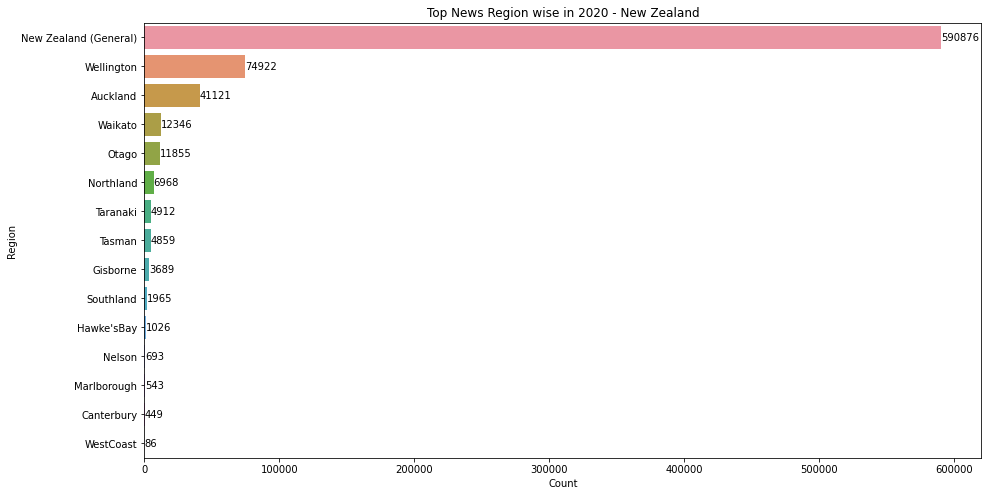

In [52]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='Count' ,y='Region',data=df_Region)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Region wise in 2020 - New Zealand")
# plt.xlabel("No")

Text(0.5, 1.0, 'Top News city wise in 2020 - Australia')

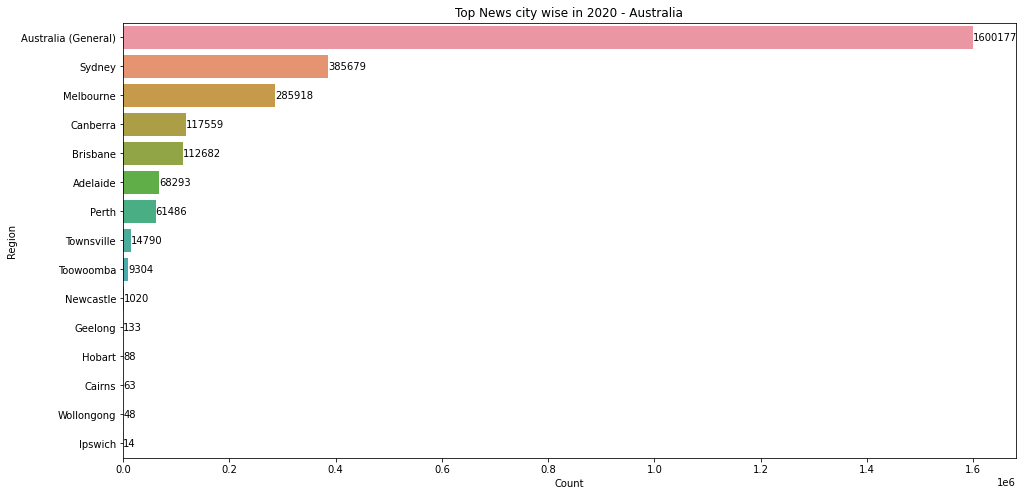

In [53]:
plt.figure(figsize=(16,8))
ax=sns.barplot(x='Count' ,y='Region',data=df_Region_au)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News city wise in 2020 - Australia")

In [54]:
df1['Sentiment'] = df1['tone'].apply(lambda x: "Positive" if x>0 else ("Neutral" if x==0 else "Negative"))
df1_au['Sentiment'] = df1_au['tone'].apply(lambda x: "Positive" if x>0 else ("Neutral" if x==0 else "Negative"))

In [55]:
df1_analysis_source = df1.groupby(['source_name', 'Sentiment']).agg({'Sentiment': ['count']}).reset_index()#.sort_values(by = 'Sentiment')
df1_analysis_source_au = df1_au.groupby(['source_name', 'Sentiment']).agg({'Sentiment': ['count']}).reset_index()#.sort_values(by = 'Sentiment')

In [56]:
df1_analysis_source.columns = df1_analysis_source.columns.droplevel(0)
df1_analysis_source_au.columns = df1_analysis_source_au.columns.droplevel(0)

In [57]:
df1_analysis_source.columns=['source_name', 'Sentiment', 'count']
df1_analysis_source_au.columns=['source_name', 'Sentiment', 'count']

Text(0.5, 0, 'Count of Articles')

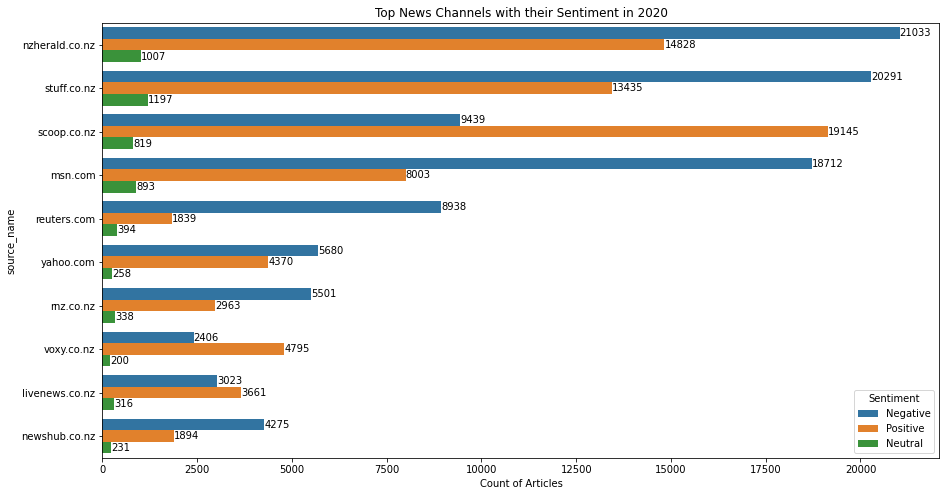

In [61]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='count',y='source_name',data=df1_analysis_source, hue = 'Sentiment', order=df1.source_name.value_counts().iloc[:10].index)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channels with their Sentiment in 2020")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

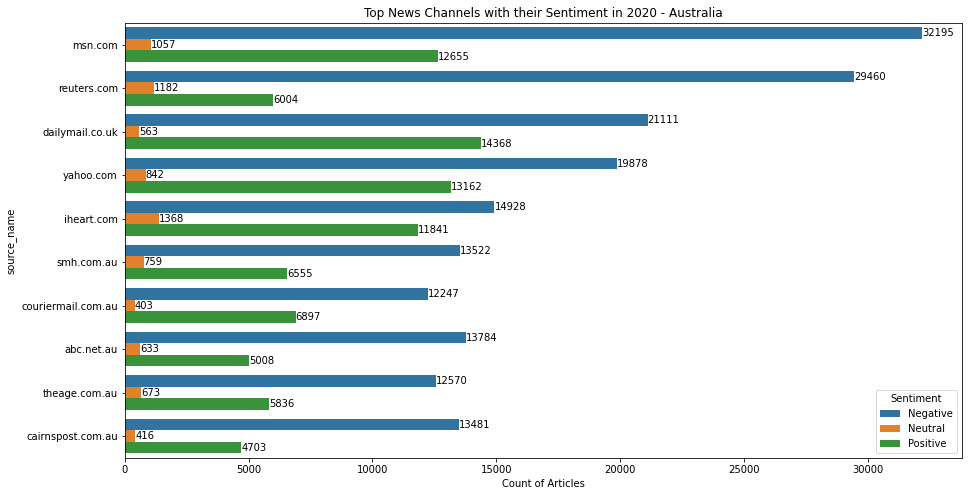

In [62]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x='count',y='source_name',data=df1_analysis_source_au, hue = 'Sentiment', order=df1_au.source_name.value_counts().iloc[:10].index)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channels with their Sentiment in 2020 - Australia")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

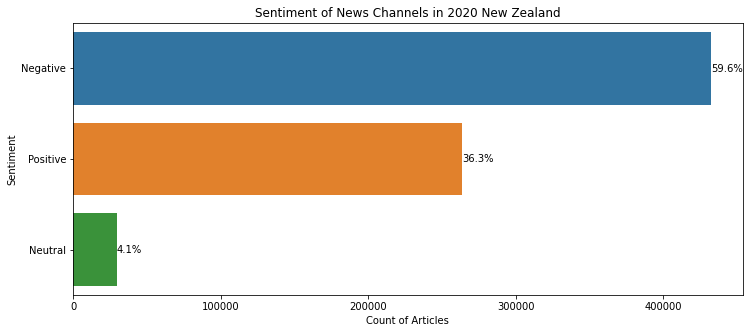

In [83]:
plt.figure(figsize=(12,5))
ax=sns.countplot(y='Sentiment',data=df1)
total = float(len(df1))
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:.1f}%'.format(100 * width/ total), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Sentiment of News Channels in 2020 New Zealand")
plt.xlabel("Count of Articles")

Text(0.5, 0, 'Count of Articles')

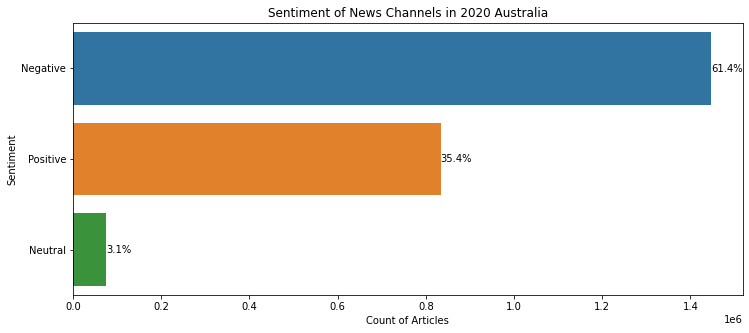

In [65]:
plt.figure(figsize=(12,5))
ax=sns.countplot(y='Sentiment',data=df1_au)
total = float(len(df1_au))
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:.1f}%'.format(100 * width/ total), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Sentiment of News Channels in 2020 Australia")
plt.xlabel("Count of Articles")

In [18]:
# df1.to_feather('df1.ft')

In [67]:
df1[df1['date'] == datetime(2020, 5, 26)]['tone'].mean()

-0.17806446491455835

### scraping Hedonometer events api

In [68]:


def hedono_api():
    response = requests.get("http://hedonometer.org/api/v1/events/?format=json&happs__timeseries__title=en_all&happs__date__gte=2019-11-01")

    print(response.status_code)

    x = response.json()
    x = json.dumps(x)
    json_parsed = json.loads(x)

    obj = json_parsed['objects']

    f = csv.writer(open("events.csv", "w"))

    h = ["date","happiness","shorter"]

    f.writerow(h)

    for x in obj:
        f.writerow([x['happs']['date'],
                    x['happs']['happiness'],
                    x['shorter']])

        
df_events = pd.read_csv("events.csv", parse_dates=['date'])

In [69]:
df1 = pd.merge(df1, df_events, on="date", how="left")
df1_au = pd.merge(df1_au, df_events, on="date", how="left")

### Comparison of Hedonometer vs GDELT

In [70]:
df1.groupby(['shorter', 'date','happiness'], as_index=False).agg({'Sentiment': pd.Series.mode}).sort_values(by = 'date')

,shorter,date,happiness,Sentiment
11,"New Year's,Day",2020-01-01,6.070,Positive
5,"Death of,Qasem Soleimani",2020-01-03,5.783,Negative
8,"Iranian,missile attack",2020-01-07,5.882,Negative
4,"Death of,Kobe Bryant",2020-01-26,5.895,Positive
16,"Valentine's,Day",2020-02-14,6.040,Negative
1,"COVID-19,Pandemic",2020-03-12,5.713,Negative
0,"Arrests for murder, of Ahmaud Arbery",2020-05-07,5.871,Negative
9,"Mother's,Day",2020-05-10,5.958,"[Negative, Positive]"
10,"Murder of,George Floyd",2020-05-26,5.870,Negative
13,"Protests against,police brutality",2020-05-31,5.628,Negative


In [71]:
df1_au.groupby(['shorter', 'date','happiness'], as_index=False).agg({'Sentiment': pd.Series.mode}).sort_values(by = 'date')

,shorter,date,happiness,Sentiment
11,"New Year's,Day",2020-01-01,6.070,Negative
5,"Death of,Qasem Soleimani",2020-01-03,5.783,Negative
8,"Iranian,missile attack",2020-01-07,5.882,Negative
4,"Death of,Kobe Bryant",2020-01-26,5.895,Negative
16,"Valentine's,Day",2020-02-14,6.040,Negative
1,"COVID-19,Pandemic",2020-03-12,5.713,Negative
0,"Arrests for murder, of Ahmaud Arbery",2020-05-07,5.871,Negative
9,"Mother's,Day",2020-05-10,5.958,Positive
10,"Murder of,George Floyd",2020-05-26,5.870,Negative
13,"Protests against,police brutality",2020-05-31,5.628,Negative


In [168]:
df1.Lockdown.value_counts()

AL 2            190321
AL 1            176213
AL 4             53576
AL 3             32447
AKL-3 Rest-2     27503
AKL-2 Rest-1     19940
Name: Lockdown, dtype: int64

In [189]:
df_lockdown = df1.groupby(['source_name','Lockdown', 'Sentiment'], as_index=False).agg(Count = ('Sentiment', 'count')).sort_values(by= 'Lockdown',ascending = False).reset_index(drop=True)

In [227]:
df_lockdown[df_lockdown['Lockdown'] == 'AL 4'].Lockdown

0       AL 4
1       AL 4
2       AL 4
3       AL 4
4       AL 4
        ... 
6773    AL 4
6774    AL 4
6775    AL 4
6776    AL 4
6777    AL 4
Name: Lockdown, Length: 6778, dtype: object

Text(0.5, 0, 'Count of Articles')

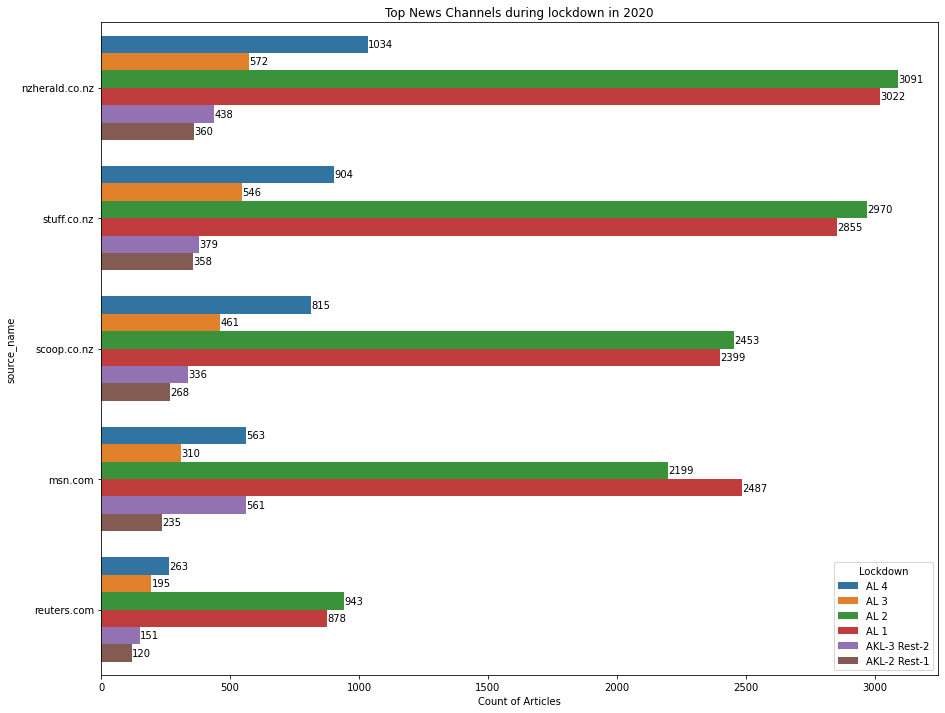

In [196]:
plt.figure(figsize=(15,12))
ax=sns.barplot(x='Count',y='source_name',data=df_lockdown, hue = 'Lockdown', order=df1.source_name.value_counts().iloc[:5].index, ci=None)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channels during lockdown in 2020")
plt.xlabel("Count of Articles")

In [77]:
def daily(df1):
    df1['date'] = df1['date'].dt.date
    df1_daily = df1.groupby(['date'], as_index=False).agg({'source_name':'count','tone':'mean', 'pos':'mean', 'neg':'mean', 'wc':'sum'})
    df1_daily['date'] = pd.to_datetime(df1_daily['date'], errors='coerce')
    df1_daily.rename(columns={'source_name': 'News_articles_count'}, inplace=True)
    
    return df1_daily


df1_daily = daily(df1)
df1_daily_au = daily(df1_au)


In [82]:
# df1_daily.to_csv("Gdelt_NZ_2020_daily_DP.csv", index = False)
# df1_daily_au.to_csv("Gdelt_NZ_2020_daily_DP_AUSTRALIA.csv", index = False)

#### S3 integration

In [60]:
import boto3

def upload_to_s3(filename, key):
    session = boto3.Session(profile_name='kandavar')
    dev_s3_client = session.client('s3')
    bucket_name = 'statsnz-covid-kandavar'
    
    dev_s3_client.put_object(Body=open(filename, 'rb'), Bucket = bucket_name, Key = filename)
    

def read_from_s3():
    
    session = boto3.Session(profile_name='kandavar')
    dev_s3_client = session.client('s3')
    bucket_name = 'statsnz-covid-kandavar'
    
    
    obj = dev_s3_client.get_object(Bucket = bucket_name, Key = filename)
    d = pd.read_csv(obj['Body'])

### Plots 

Text(0.5, 1.0, 'Top News Channel in 2020')

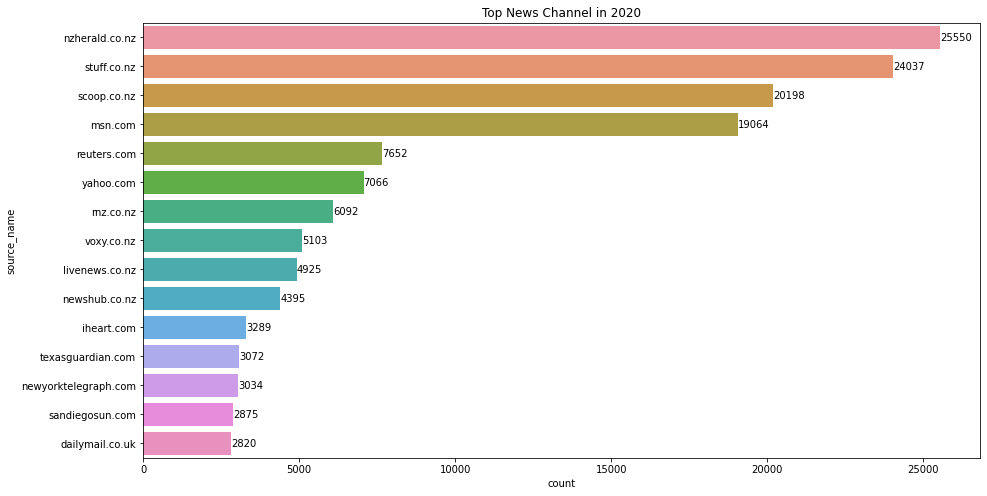

In [27]:
plt.figure(figsize=(15,8))
ax=sns.countplot(y='source_name',data=df1, order=df1.source_name.value_counts().iloc[:15].index)
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
plt.title("Top News Channel in 2020")
# plt.xlabel("No")

<AxesSubplot:xlabel='date', ylabel='tone'>

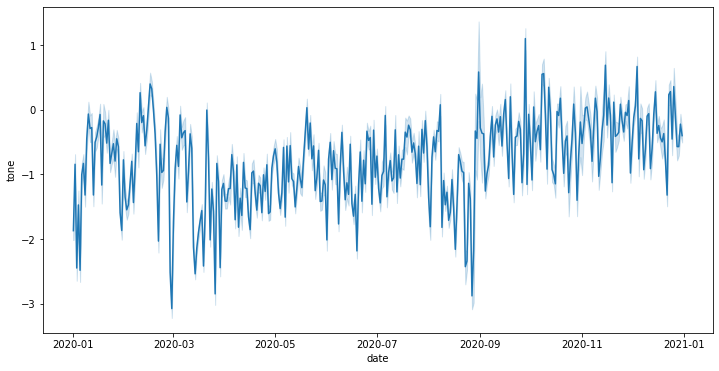

In [65]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='tone',data=df1)

<AxesSubplot:xlabel='date', ylabel='tone'>

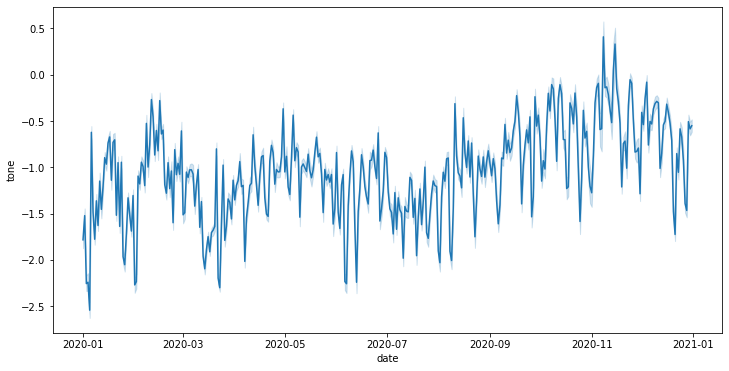

In [80]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='tone',data=df1_au)

In [106]:
from bokeh.plotting import figure, output_notebook, show

output_notebook()

Loading BokehJS ...

In [112]:
df1_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 366 non-null    datetime64[ns]
 1   News_articles_count  366 non-null    int64         
 2   tone                 366 non-null    float64       
 3   pos                  366 non-null    float64       
 4   neg                  366 non-null    float64       
 5   wc                   366 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 20.0 KB


In [110]:
fig = figure(title='Daily Sentiment - Nz (2020)',
             x_axis_label='date',
             y_axis_label='tone',
             width=1200,
             height=600)

fig.line(df1_daily.date, df1_daily.tone, 
         line_alpha=0.8,
         legend_label='Sentiment tone', 
         line_width=2)

show(fig)